# Pothole Detection

### Dataset Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing all the required libraries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from keras.applications.resnet50 import ResNet50

## Dataset is divided into two parts : test & train
### Both the directories (test and train) are divided further : Plain & Pothole

In [ ]:
os.listdir('/content/drive/MyDrive/My Dataset')

['test', 'train']

Resizing the images into (256 * 256) 

In [ ]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            
            

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [ ]:
X=[]
Z=[]
IMG_SIZE=256
Plain='/content/drive/MyDrive/My Dataset/train/Plain'
Pothole='/content/drive/MyDrive/My Dataset/train/Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 357/357 [02:16<00:00,  2.61it/s]


## Displaying the training data with labels

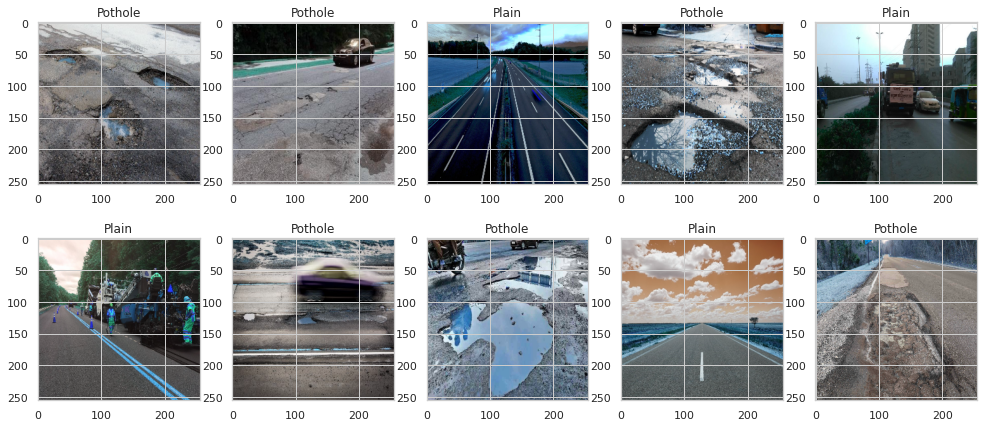

In [ ]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

## Splitting the data into Training and Validation data

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Building the CNN model using RESNET (pretrained model)

In [ ]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the resnet model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 30,408,066
Trainable params: 30,354,946
Non-trainable params: 53,120
_______________________________________

In [ ]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
17/17 [==============================] - 21s 552ms/step - loss: 2.0014 - accuracy: 0.5249 - val_loss: 0.8922 - val_accuracy: 0.6906
Epoch 2/50
17/17 [==============================] - 7s 405ms/step - loss: 0.3844 - accuracy: 0.8702 - val_loss: 0.1990 - val_accuracy: 0.9171
Epoch 3/50
17/17 [==============================] - 7s 408ms/step - loss: 0.0988 - accuracy: 0.9623 - val_loss: 0.1790 - val_accuracy: 0.9392
Epoch 4/50
17/17 [==============================] - 7s 410ms/step - loss: 0.0806 - accuracy: 0.9830 - val_loss: 0.1306 - val_accuracy: 0.9503
Epoch 5/50
17/17 [==============================] - 7s 413ms/step - loss: 0.0592 - accuracy: 0.9831 - val_loss: 0.1314 - val_accuracy: 0.9503
Epoch 6/50
17/17 [==============================] - 7s 417ms/step - loss: 0.0186 - accuracy: 0.9981 - val_loss: 0.1283 - val_accuracy: 0.9558
Epoch 7/50
17/17 [==============================] - 7s 421ms/step - loss: 0.0163 - accuracy: 0.9888 - val_loss: 0.1232 - val_accuracy: 0.9558
Epoch

## Saving the trained model

In [ ]:
model.save('../ResNetModel.h5')

## Model Accuracy

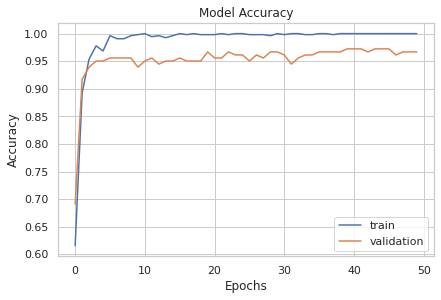

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Model Loss

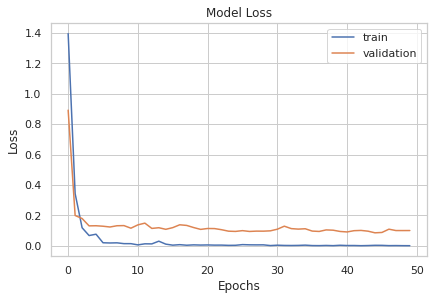

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Testing the trained model 
### [0,1] --> Pothole road
### [1,0] --> Plain road

### Testing the trained model on Pothole images

In [ ]:
path = "/content/drive/MyDrive/My Dataset/test/Pothole"
files = os.listdir(path)
files

['5.jpg', '6.jpg', '2.jpg', '4.jpg', '8.jpg', '3.jpg', '1.jpg', '7.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

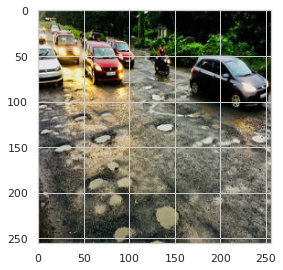

 12%|█▎        | 1/8 [00:01<00:10,  1.57s/it]

Pothole Road


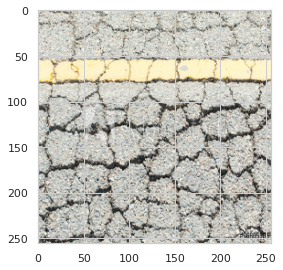

 25%|██▌       | 2/8 [00:02<00:07,  1.32s/it]

Pothole Road


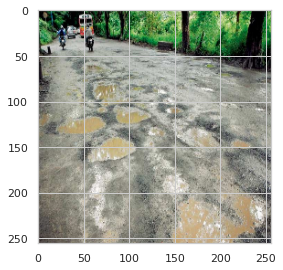

 38%|███▊      | 3/8 [00:02<00:05,  1.10s/it]

Pothole Road


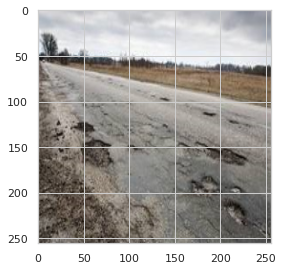

 50%|█████     | 4/8 [00:03<00:03,  1.09it/s]

Pothole Road


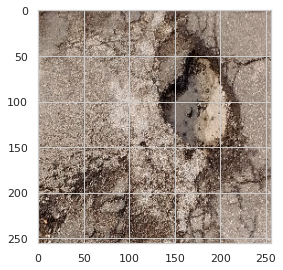

 62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

Pothole Road


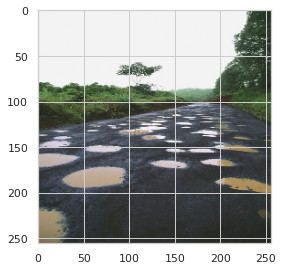

 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

Pothole Road


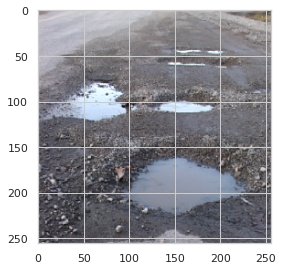

 88%|████████▊ | 7/8 [00:05<00:00,  1.17it/s]

Pothole Road


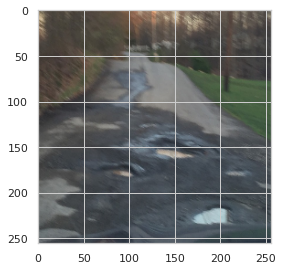

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Pothole Road


In [ ]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

### Testing the trained model on Plain images

In [ ]:
path = "/content/drive/MyDrive/My Dataset/test/Plain"
files = os.listdir(path)
files

['3.jpg', '6.jpg', '8.jpg', '7.jpg', '5.jpg', '4.jpg', '2.jpg', '1.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

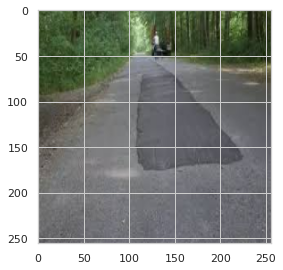

 12%|█▎        | 1/8 [00:00<00:03,  1.98it/s]

Pothole Road


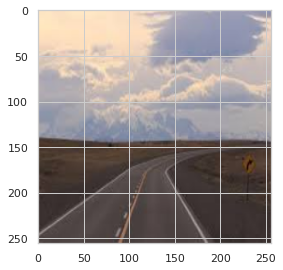

 25%|██▌       | 2/8 [00:01<00:03,  1.96it/s]

Plain Road


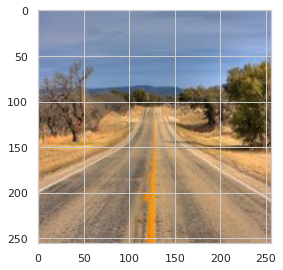

 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

Plain Road


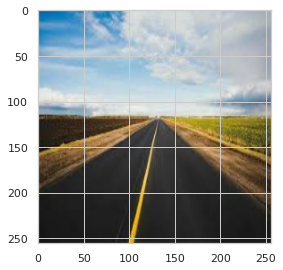

 50%|█████     | 4/8 [00:02<00:02,  1.92it/s]

Plain Road


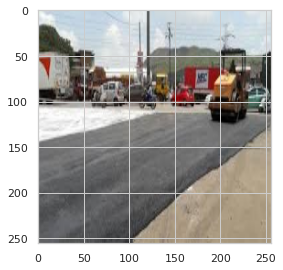

 62%|██████▎   | 5/8 [00:02<00:01,  1.93it/s]

Pothole Road


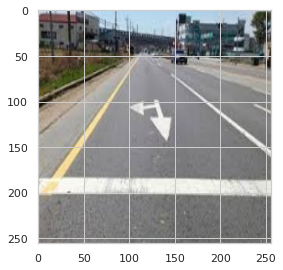

 75%|███████▌  | 6/8 [00:03<00:01,  1.90it/s]

Plain Road


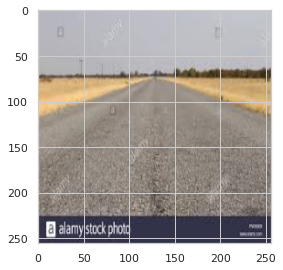

 88%|████████▊ | 7/8 [00:03<00:00,  1.93it/s]

Plain Road


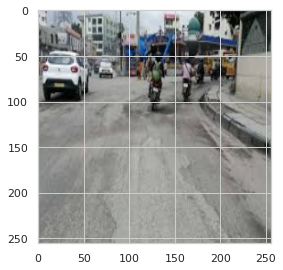

100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

Pothole Road


In [ ]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")